In [2]:
%pip install pmdarima
%pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 11.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as auto_corr

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

import math
from datetime import datetime
from datetime import timedelta

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

import warnings
warnings.filterwarnings("ignore")

## Model Building

### Using RandomForest Regressor

Random Forest is a collection of decision trees which is used for regression tasks by averagin out the outputs produced by all the Decision trees.

We can use Weighted Mean Absolute Error(WMAE) to know the accuracy of the model

Here,
| Feature | Description |
|---|---|
| n | Number of rows in the dataset |
| ŷᵢ | Predicted sales for observation i |
| yᵢ | Actual sales for observation i |
| wᵢ | Weight for observation i: <br> w= 5 if the week is a holiday week, 1 otherwise |

In [4]:
pd.options.display.max_columns=100

In [5]:
df = pd.read_csv('data_cleaned.csv')

In [6]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,True,False,False,False,6,2,2010
2,2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,False,7,2,2010
3,3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,False,8,2,2010
4,4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,False,9,3,2010


In [7]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

#### Data Encoding

to encode data we encode true and false in the Holidays to 0-1 and store types form A,B,C to 1,2,3

In [9]:
df_encoded = df.copy()
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original


#### Checking for multicollinearity between features

now we dont need the individual column for holidays so we can drop them

In [10]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)

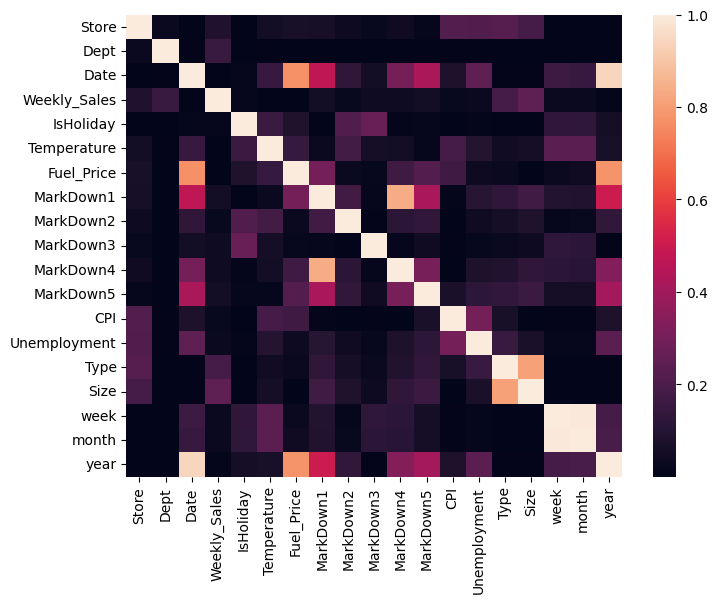

In [11]:
plt.figure(figsize = (8,6))
sns.heatmap(df_new.corr().abs())
plt.show()

we know that Temparature, Unemployement, CPI have no significant impacct on weekly sales so we can drop them. Also we can observe that MArkdown 4 and 5 ae highly correlated with MArkdown 1 so we can drop them also.

In [12]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True)

now let's plot the graph again

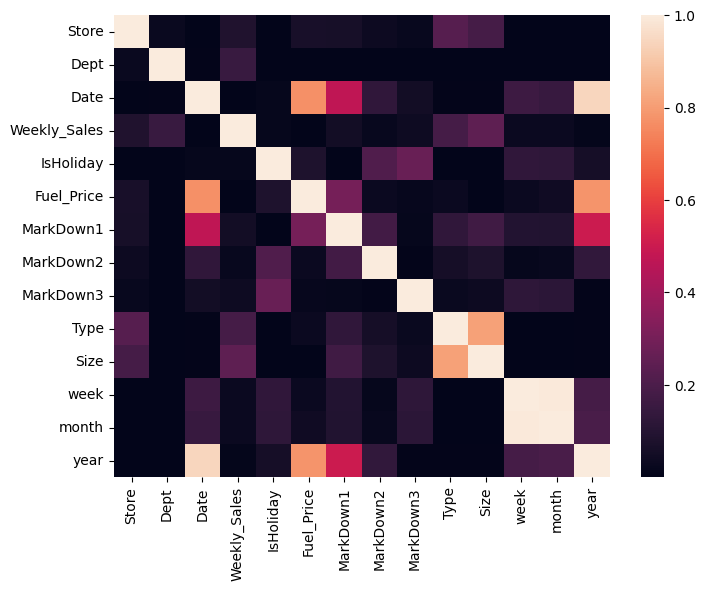

In [13]:
plt.figure(figsize = (8,6))
sns.heatmap(df_new.corr().abs())
plt.show()

sorting according to date

In [14]:
df_new = df_new.sort_values(by='Date', ascending=True)

### Creaitng train-test splits

as the date column has continuous values we should not take random splitting so we have to split manually,To avoid data leakage, we typically use a time-based split

In [15]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [16]:
X = df_new[used_cols] # to keep train and test X values together

In [17]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

we have to define the weighted mean absolute error as it is not from thelibraries

In [18]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

### Implementing Random Forest Regressor

In [19]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [20]:
wmae_test(y_test, y_pred_test)

5697.712824122053

for the first trail the WMAE is around 5697

In [21]:
X = X.drop(['Date'], axis=1)

to check for feature importance form Bryan Arnold's notebook

Feature ranking:
1. feature 1 (0.734834)
2. feature 8 (0.103608)
3. feature 0 (0.058842)
4. feature 7 (0.039401)
5. feature 9 (0.021299)
6. feature 3 (0.018655)
7. feature 10 (0.008636)
8. feature 6 (0.005390)
9. feature 4 (0.003045)
10. feature 5 (0.002715)
11. feature 2 (0.002032)
12. feature 11 (0.001543)


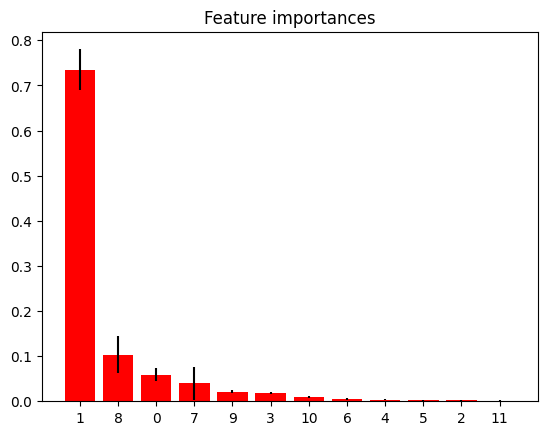

In [22]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

These scores represent the relative contribution of each feature to the model's predictions.

now lets train again without Month(11th feature)

In [23]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

In [24]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [25]:
wmae_test(y_test, y_pred_test)

5450.408821519322

we get a better result than before

Now  lets check the models performance on the whole encoded data without dropping any columns

In [26]:

# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [27]:
X_enc = df_encoded[used_cols1]

In [28]:
X_enc = X_enc.drop(['Date'], axis=1)

In [29]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [30]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [31]:
wmae_test(y_test_enc, y_pred_test_enc)

2684.1200397952525

we get even lesser WMAE so we found out that the model can learn much better form the dropped columns so we dont drop them

feature importance of the whole dataset

Feature ranking:
1. feature 1 (0.743021)
2. feature 13 (0.073903)
3. feature 12 (0.040787)
4. feature 0 (0.033258)
5. feature 10 (0.030062)
6. feature 11 (0.017276)
7. feature 18 (0.011946)
8. feature 3 (0.011041)
9. feature 4 (0.010113)
10. feature 19 (0.005986)
11. feature 7 (0.004673)
12. feature 9 (0.003993)
13. feature 8 (0.003554)
14. feature 5 (0.003447)
15. feature 6 (0.002533)
16. feature 20 (0.001175)
17. feature 16 (0.001059)
18. feature 2 (0.000916)
19. feature 17 (0.000683)
20. feature 15 (0.000301)
21. feature 14 (0.000272)


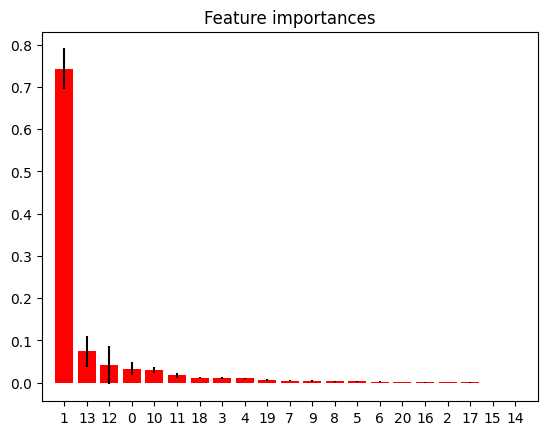

In [32]:

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [33]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

Now lets model according to the feature importances

In [34]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [35]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,max_features = 'log2',min_samples_split = 5)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [36]:
pipe.score(X_test_enc1,y_test_enc1)

0.7565524449992068

In [37]:
wmae_test(y_test_enc1, y_pred_test_enc)

1846.1978998324716

w/o month column

In [38]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [39]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [40]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)


In [41]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [42]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [43]:

pipe.score(X_test_enc2,y_test_enc2)

0.719191227838875

In [44]:
wmae_test(y_test_enc2, y_pred_test_enc)

2040.3780426408082

displaying the resutls

In [45]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together


In [46]:
# writing results to df
new_results = [
    {"Model": 'RandomForestRegressor', "Info": 'w/out divided holiday columns', 'WMAE': 5697.71},
    {"Model": 'RandomForestRegressor', "Info": 'w/out month column', 'WMAE': 5450.40},
    {"Model": 'RandomForestRegressor', "Info": 'whole data', 'WMAE': 2684.12},
    {"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection', 'WMAE': 1846.19},
    {"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection w/out month', 'WMAE': 2040.37},
]

# Convert new results to a DataFrame
new_results_df = pd.DataFrame(new_results)

# Concatenate the new results with the existing DataFrame
df_results = pd.concat([df_results, new_results_df], ignore_index=True)

# Display the updated DataFrame
df_results.head()

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5697.71
1,RandomForestRegressor,w/out month column,5450.40
2,RandomForestRegressor,whole data,2684.12
3,RandomForestRegressor,whole data with feature selection,1846.19
4,RandomForestRegressor,whole data with feature selection w/out month,2040.37


### Time series Models(ARIMA)

we are not using neural networks as ARIMA is better at providing predictions of Stationary data in our case

In [47]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,True,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,False,9,3,2010


In [48]:
df["Date"] = pd.to_datetime(df["Date"])

df.set_index('Date', inplace=True)

we check the sales for each week by plottin them

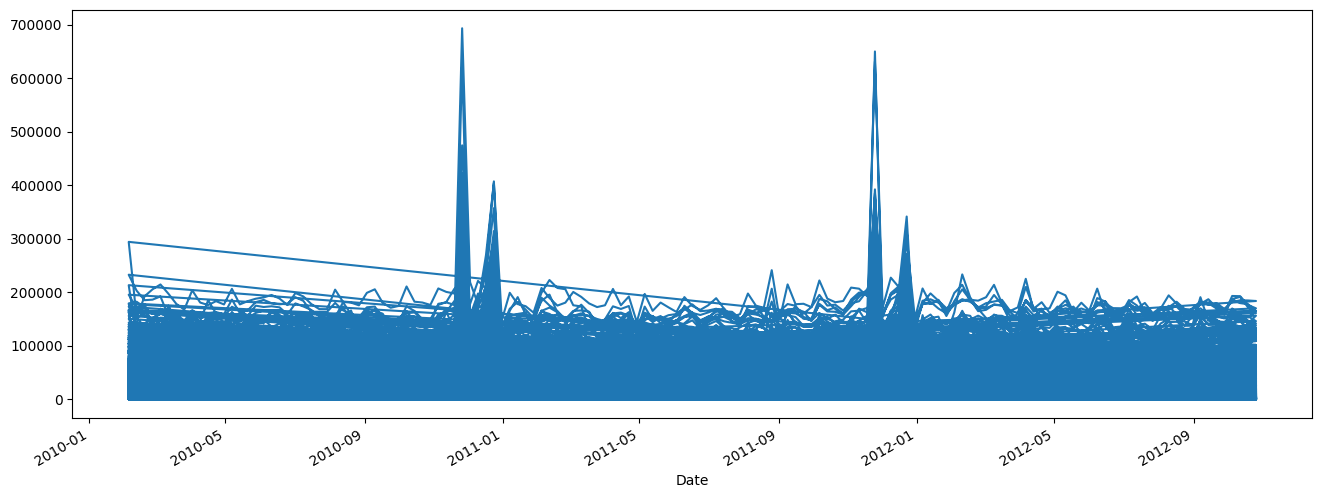

In [49]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, wewill collect them together as weekly

In [50]:
numeric_columns = df.select_dtypes(include=[np.number])  # Select numeric columns
df_week = numeric_columns.resample('W').mean()

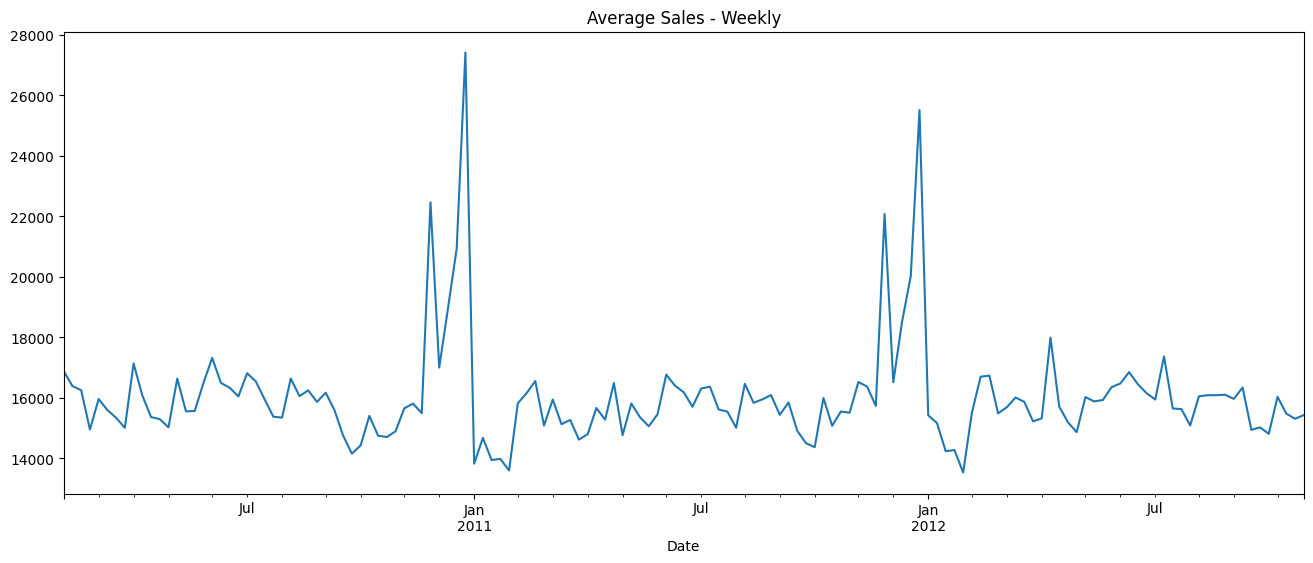

In [51]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

we can observe the same trand as we observed in the EDA

In [52]:
df_month = numeric_columns.resample('MS').mean()

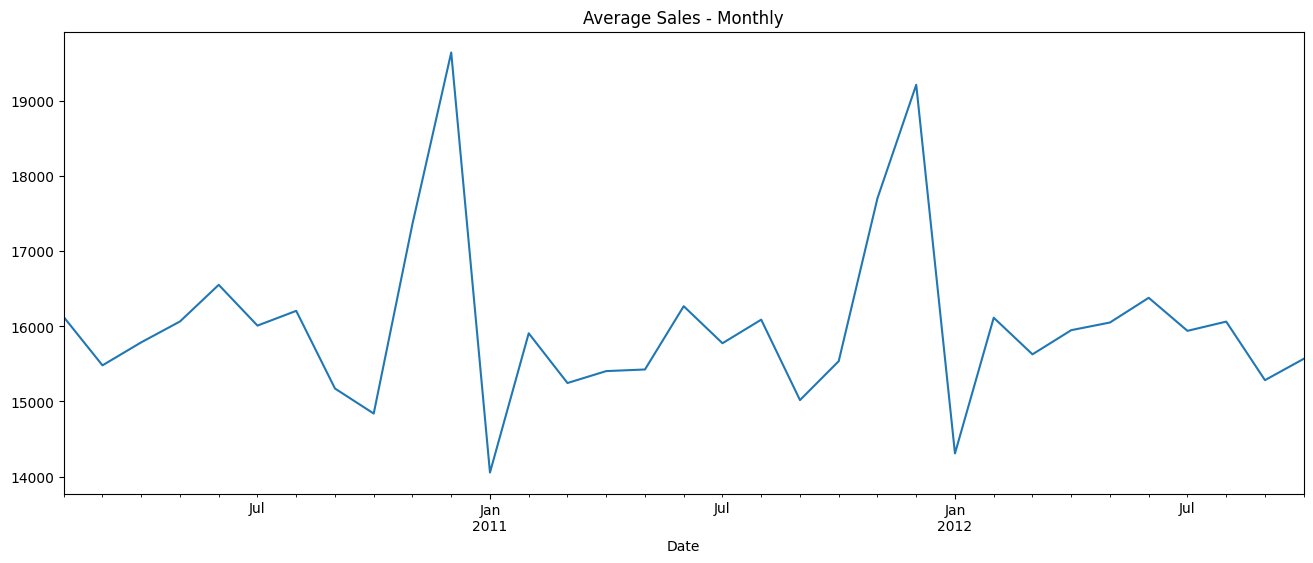

In [53]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

weekly data was better at displaying the trends of the weekly average sales

now we take a look at the Rolling mean and the Standard Deviation as the data is non stationary and we need to make it stationary

In [54]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

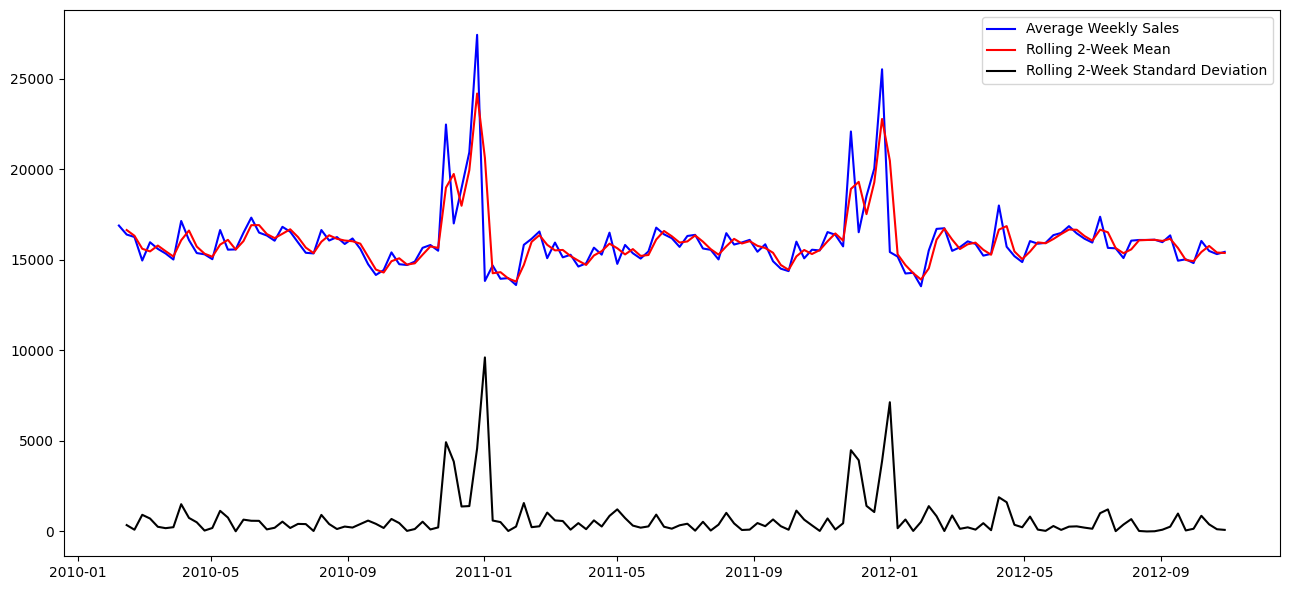

In [55]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

#### Adfuller Test

its is used to determine whether a given time series is staitonary or not

In [56]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

we find that out data is not stationary

now we split the data on the basis of weeks

we need to split manually as done before

In [57]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 16)
Test: (43, 16)


In [58]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

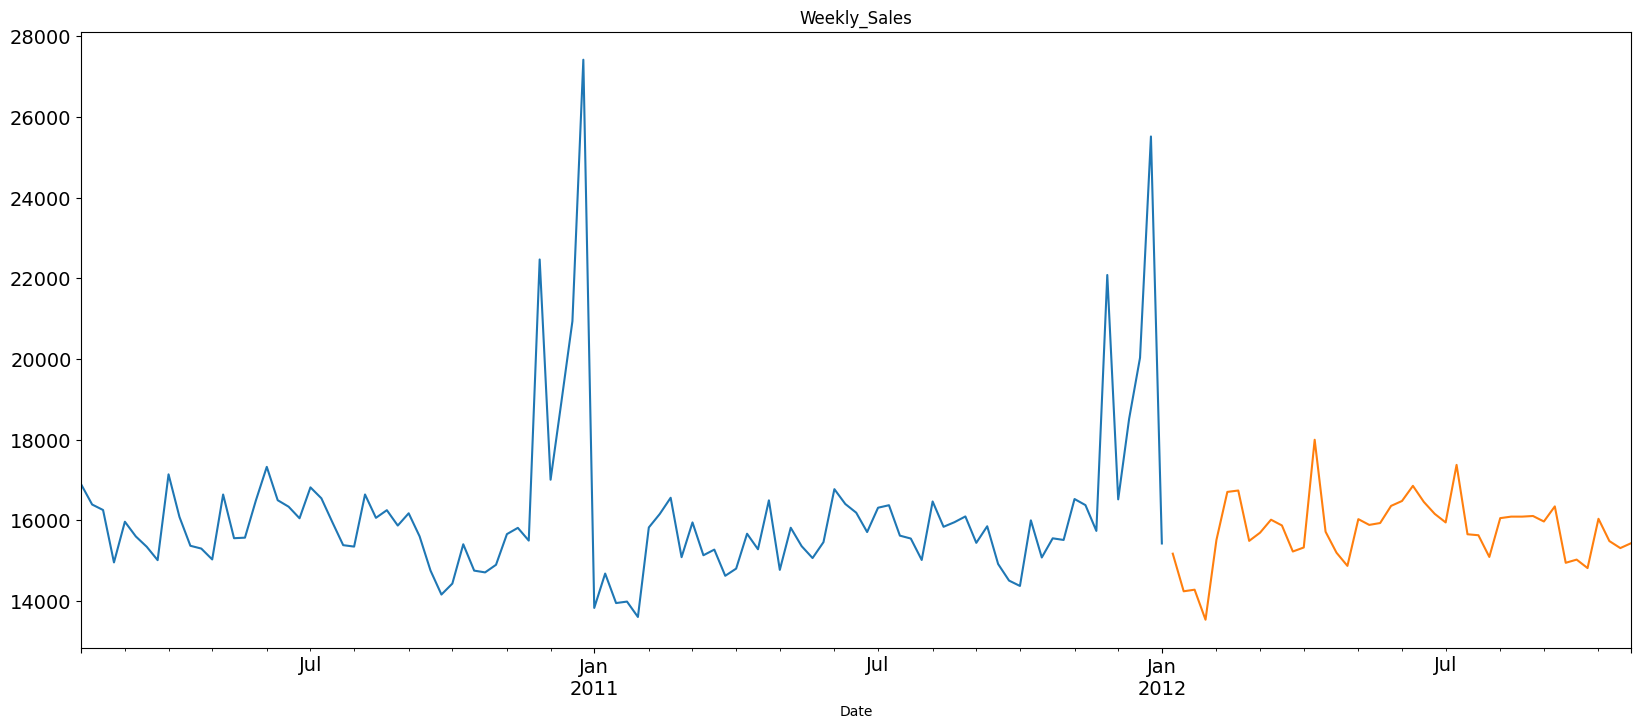

In [59]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

yellow line is the test set and the blue line is the training data

#### Observing seasonality by decomposing weekly data

In [60]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

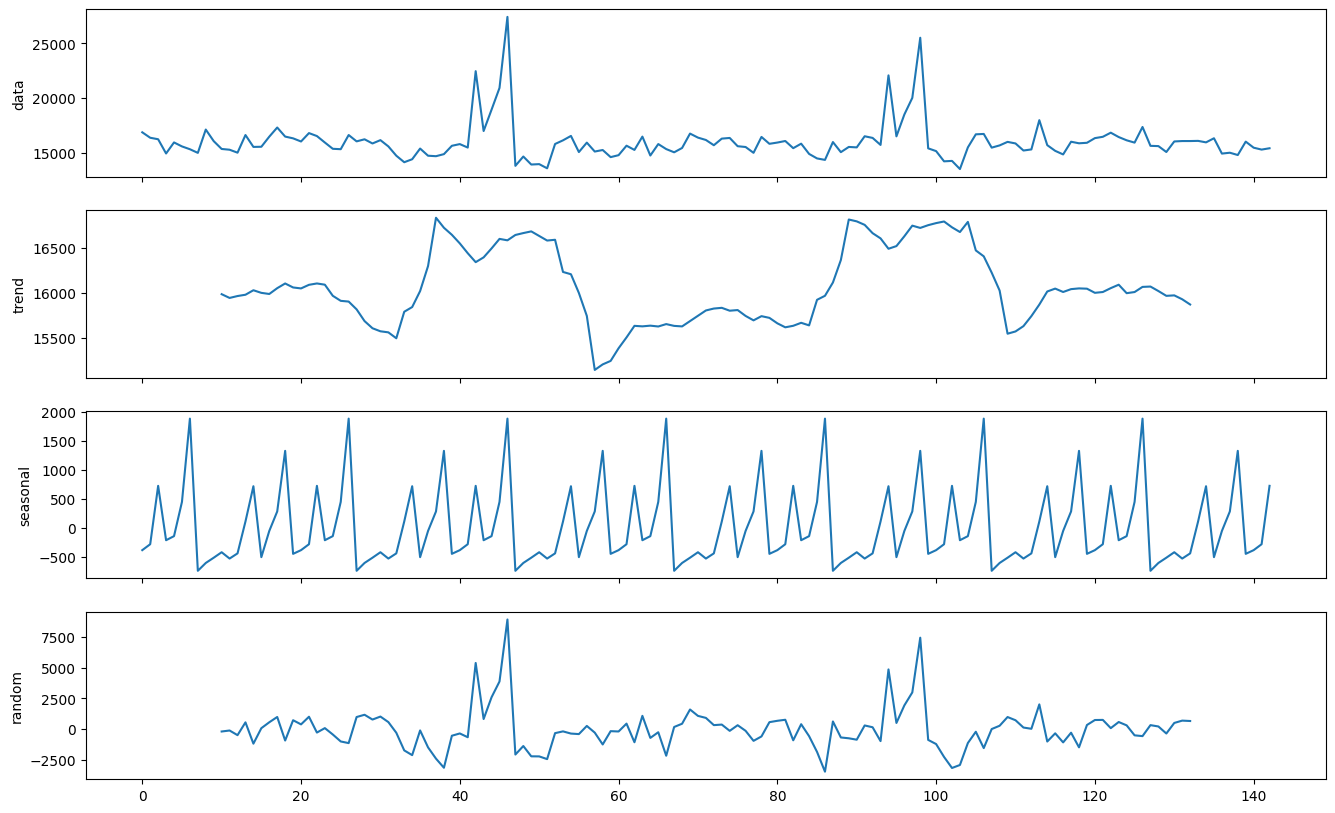

In [61]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

making data more stationary

- using differences

In [62]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values


In [63]:
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

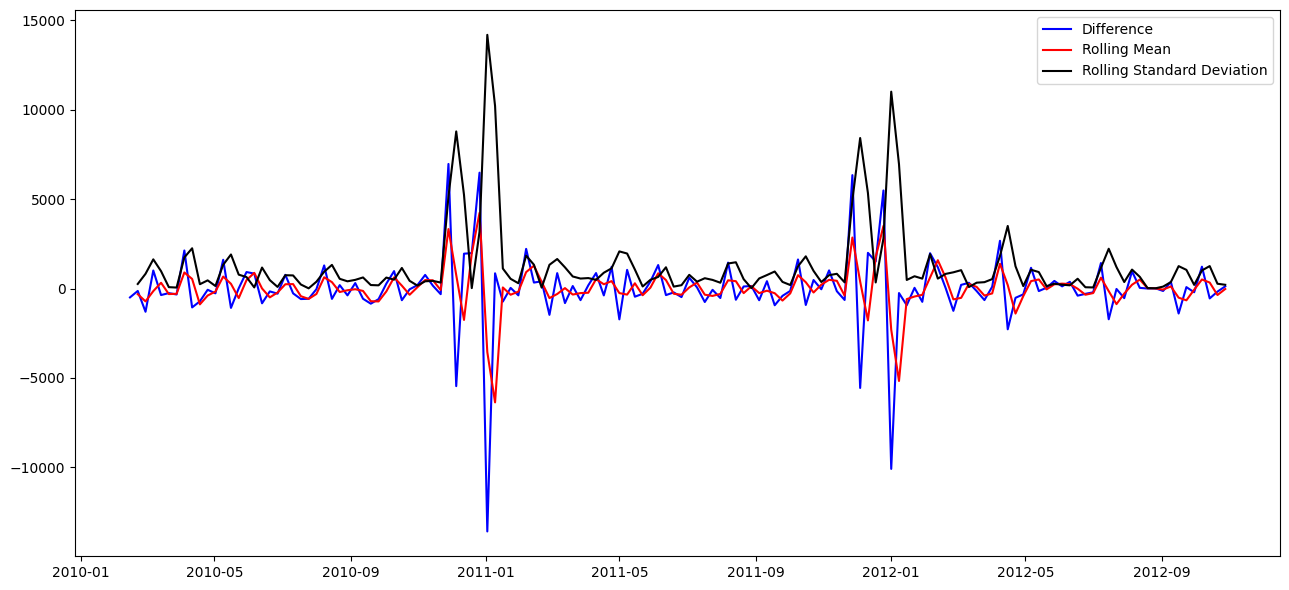

In [64]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

- by shifting the data

In [65]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data


In [66]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

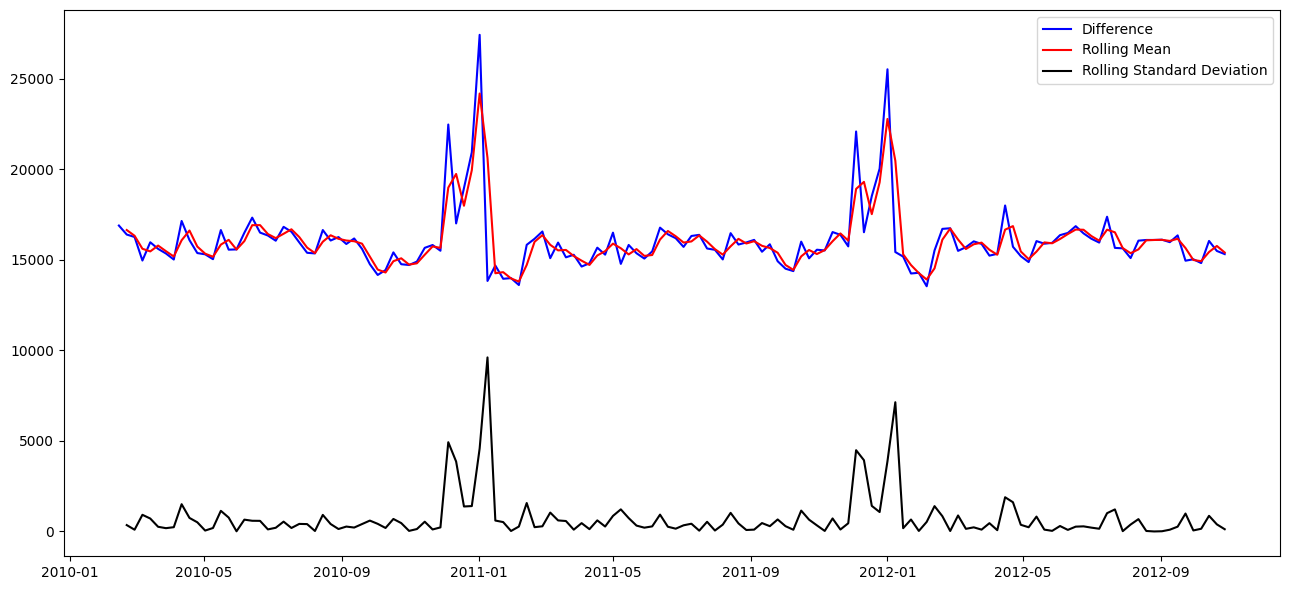

In [67]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

- by taking the log of data

In [68]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data


In [69]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

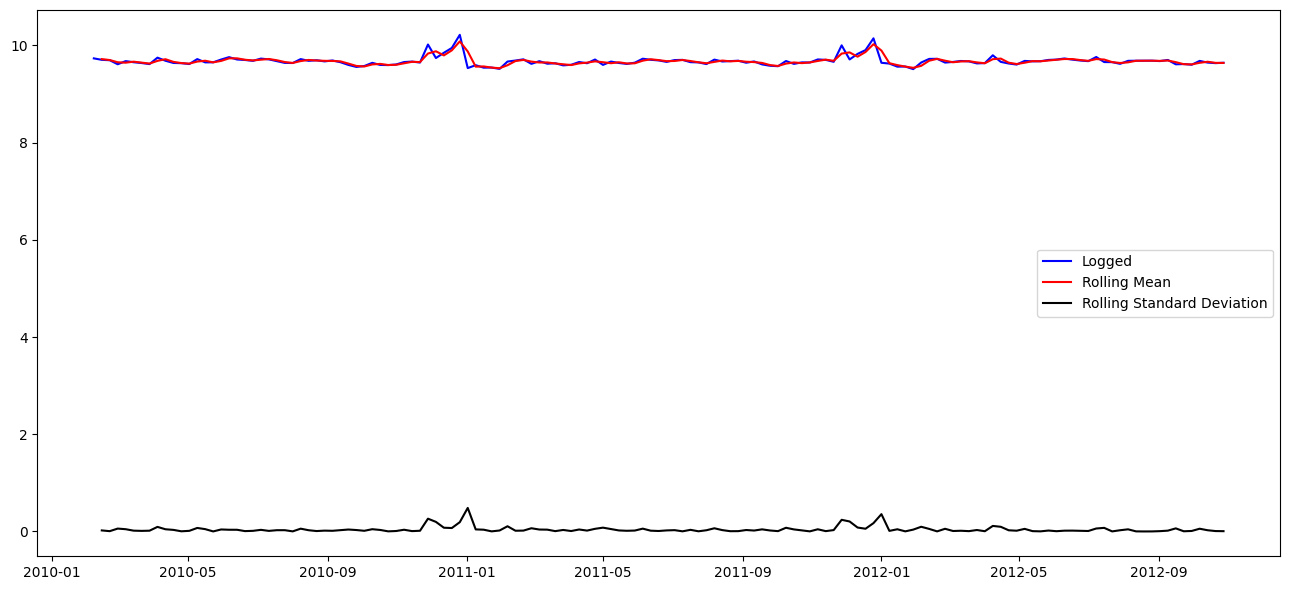

In [70]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

#### AUTO ARIMA MODEL

In [71]:

train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [72]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.76 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.69 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

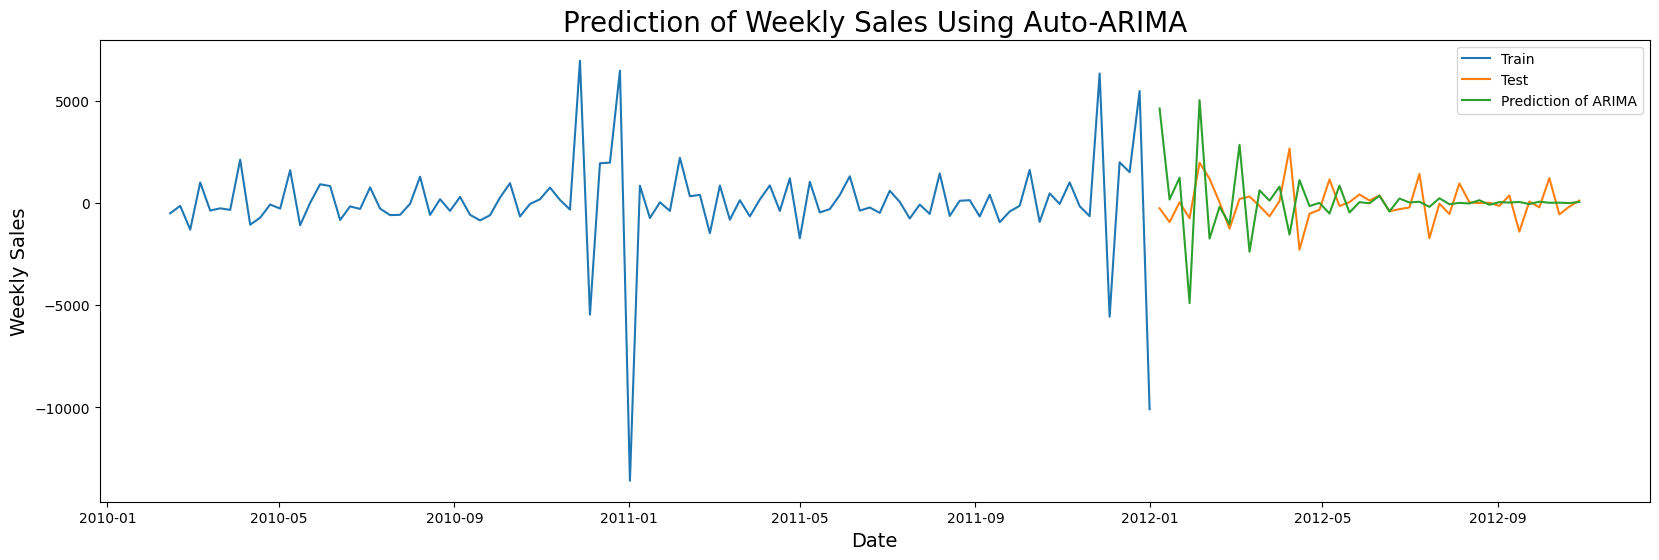

In [73]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

### ExponentialSmoothing

Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

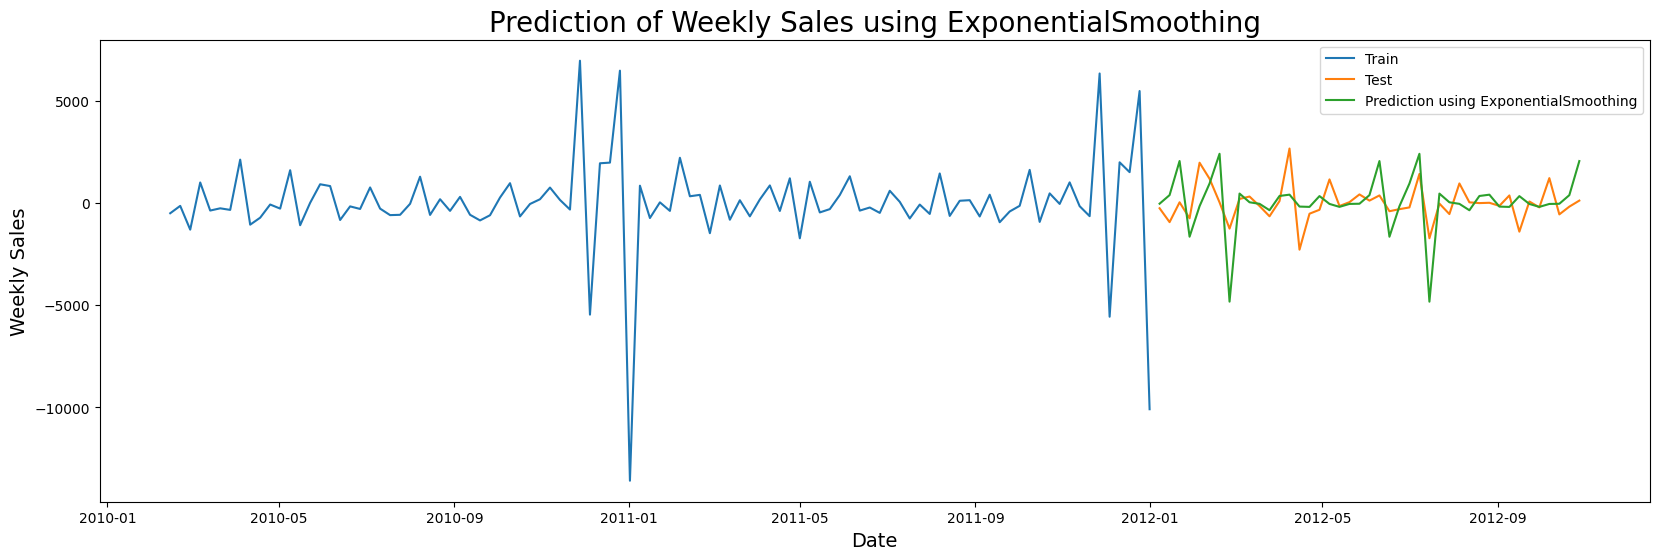

In [77]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [80]:
test_data_diff.head()

,Weekly_Sales
Date,
2012-01-08,-252.844934
2012-01-15,-931.949950
2012-01-22,39.198689
2012-01-29,-744.082450
2012-02-05,1976.337032


In [87]:
y_pred = y_pred.rename('Weekly_Sales')

In [88]:
y_pred.head()

,Weekly_Sales
2012-01-08,-29.499387
2012-01-15,391.433966
2012-01-22,2059.746539
2012-01-29,-1645.060769
2012-02-05,-151.354319


In [89]:
mae = np.mean(np.abs(test_data_diff - y_pred))
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Absolute Error (MAE): 923.12
